<a href="https://colab.research.google.com/github/zuyeyang/Wind_Turbine_Q_Learning/blob/main/semiactive_damper_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
from scipy import integrate
import pandas as pd
import matplotlib.pyplot as plt

['\ufeffName', 'Date time', 'Wind Speed', 'Wind Direction']


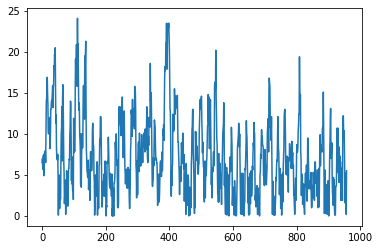

In [ ]:
import csv
file = open('/content/gdrive/MyDrive/work/stanford/coursework/cs238/project/wind_data.csv')
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
windspeeds = []
for row in csvreader:
    if len(row[2])>0:
      windspeeds.append(float(row[2]))
plt.plot(windspeeds)

# Damper paramters
https://ascelibrary.org/doi/pdf/10.1061/%28ASCE%290733-9399%281997%29123%3A3%28230%29

https://journals.sagepub.com/doi/pdf/10.1177/107754602023712


#W --> F --> D --> R

Task
- Benson: wind data 
+ Problem formulation
+ Get the simulation with wind data (Jingxiao) --> project 2 format --> policy
+ algorithm
 -- 1. baseline: no control, random control
 -- 2. Q-learning --> policy
 -- 3. Hindsight


In [ ]:
class semiactive_damper:
    def __init__(self,dt,u0=0):
        self.z = [[0,0]] # state
        self.x = [[0,0,0]] #
        self.u = [u0] # voltage
        self.c0a = 5000 # Ns/m
        self.c0b = 5000 # Ns/mV
        self.k0 = 10000 # N/m
        self.c1a = 5000 # Ns/m
        self.c1b = 5000 # Ns/mV
        self.k1 = 10000 # N/m
        self.x0 = self.x[0][0] # m
        self.alpha_a = 14000 # N/m
        self.alpha_b = 69500 # N/mV
        self.gamma = 0.0363 # m^-2
        self.beta = 0.0363 # m^-2
        self.A = 300
        self.n = 2
        self.eta = 190 # s^-1
        self.m = 70000 # kg
        self.dt = dt

    def dudt(self, u, t, vol, c):
        return -self.eta*(u-vol)

    def bouc_wen(self, state, t, x, dx, vol):
        y,z = state
        alpha = self.alpha_a+self.alpha_b*vol
        c0 = self.c0a+self.c0b*vol
        c1 = self.c1a+self.c1b*vol
        dydt = (1 / (c0 + c1)) * (alpha * z + c0 * dx + self.k0 * (x - y))
        dzdt = -self.gamma * abs(dx - dydt) * abs(z) ** (self.n - 1) * z - \
               self.beta * (dx - dydt) * abs(z) ** self.n + self.A * (dx - dydt)
        return np.array([dydt, dzdt])

    def damper_force(self, disp, vel, vol):
        z0 = self.z[-1]
        u0 = self.u[-1]
        vols = integrate.odeint(self.dudt, u0, [0, self.dt], args=(vol, 0))
        vol = vols[-1][0]
        self.u.append(vol)   
        state = integrate.odeint(self.bouc_wen, z0, [0,self.dt], args=(disp, vel, vol))
        y,z = state[-1]
        self.z.append(state[-1])
        alpha = self.alpha_a+self.alpha_b*vol
        c0 = self.c0a+self.c0b*vol
        c1 = self.c1a+self.c1b*vol
        dydt = (1 / (c0 + c1)) * (alpha * z + c0 * vel + self.k0 * (disp - y))
        return -(dydt*c1+self.k1*(disp-self.x0))

    def newmarkB(self,force):
        x0,dx0,ddx0 = self.x[-1]
        vol= self.u[-1]
        c = self.c1a
        x = (self.m/self.dt**2*(4*x0+4*dx0*self.dt+ddx0*self.dt**2)\
             +c/self.dt*(2*x0+dx0*self.dt)\
             + force)/(4*self.m/self.dt**2+4*c/dt+self.k1)
        dx = 2/self.dt*(x-x0)-dx0
        ddx = 4/dt**2*(x-x0-dx0*dt-dt**2/4*ddx0)
        self.x.append([x,dx,ddx])

    def reset(self):
        self.z = [[0,0]] # state
        self.x = [[0,0,0]] #
        self.u = [0] # voltage

In [ ]:
def windforce(St,D,U,t):
  Wf = 2*np.pi*St*U/D
  force = 100*np.array([np.sin(Wf*i) for i in t])
  return force

In [ ]:
T = 30
dt = 0.01
times = np.linspace(0,T,int(T/dt))
St = 0.22
D = 5
# omega = 2*np.pi*1
# disp = 0.01*np.sin(omega*times)
# vel = omega*0.01*np.cos(omega*times)
volts = np.linspace(0,200,21)
# windspeeds = np.linspace(2,20,10)*0.44
max_disp = np.zeros((len(volts)-1,len(windspeeds)))
dispm = []
velm = []
accm = []
dispm_0 = []
velm_0 = []
accm_0 = []
displ = []
vell = []
accl = []
prev_displ = []
prev_vell = []
prev_accl = []
act = []
wspd = []
nxt_wspd = []
prev_xs = [[0,0,0]]
# for w in range(len(windspeeds)-1):
for w in range(400,500):
      disps = np.zeros((len(volts),len(times)))
      vels = np.zeros((len(volts),len(times)))
      accs = np.zeros((len(volts),len(times)))
      forces = windforce(St,D,windspeeds[w]*0.44,times)
      if len(prev_xs) > 11:
          prev_xs = prev_xs[np.random.choice(len(prev_xs), 3, replace=False)]
      tmp_prev_xs = []
      for prev_x in prev_xs:
          for n in range(len(volts)):
              sad = semiactive_damper(dt,volts[n])
              semiactive_force = [0]
              sad.reset()
              sad.x = [prev_x]
              for i in range(len(times)):
                  sad.newmarkB(-semiactive_force[-1]+forces[i])
                  disp,vel,acc = sad.x[-1]
                  if np.sign(disp)*np.sign(vel) > 0:
                      voltage = 0
                  else:
                      voltage = volts[n] 
                  semiactive_force.append(-sad.damper_force(disp,vel,voltage))
              disps[n,:] = np.array(sad.x)[1:,0]
              vels[n,:] = np.array(sad.x)[1:,1]
              accs[n,:] = np.array(sad.x)[1:,2]
              if n == 0:
                  disp_0 = max(abs(disps[n,:]))
                  vel_0 = max(abs(vels[n,:]))
                  acc_0 = max(abs(accs[n,:]))
              if n > 0:
                  max_disp[n-1,w] = max(abs(disps[n,:]))
                  dispm.append(max(abs(disps[n,:])))
                  velm.append(max(abs(vels[n,:])))
                  accm.append(max(abs(accs[n,:])))
                  dispm_0.append(disp_0)
                  velm_0.append(vel_0)
                  accm_0.append(acc_0)
                  displ.append(sad.x[-1][0])
                  vell.append(sad.x[-1][1])
                  accl.append(sad.x[-1][2])
                  prev_displ.append(prev_x[0])
                  prev_vell.append(prev_x[1])
                  prev_accl.append(prev_x[2])
                  wspd.append(windspeeds[w]*0.44)
                  act.append(volts[n])
                  nxt_wspd.append(windspeeds[w+1]*0.44)
              tmp_prev_xs.append(sad.x[-1])
      prev_xs = np.array(tmp_prev_xs)

In [ ]:
data_dict = {'prev_displ':prev_displ,'prev_vell':prev_vell,'prev_accl':prev_accl,'wspd':wspd,
             'displ':displ,'vell':vell,'accl':accl,'nxt_wspd':nxt_wspd,'act':act,
             'dispm':dispm,'velm':velm,'accm':accm,
             'dispm_0':dispm_0,'velm_0':velm_0,'accm_0':accm_0,}
data = pd.DataFrame(data_dict)

In [ ]:
data.iloc[0:50,:]

,prev_displ,prev_vell,prev_accl,wspd,displ,vell,accl,nxt_wspd,act,dispm,velm,accm,dispm_0,velm_0,accm_0
0,0.000000,0.000000,0.000000,2.86,-1.009082e-04,-0.000005,6.046908e-05,3.080,10.0,0.000107,0.000142,0.000336,0.000108,0.000142,0.000336
1,0.000000,0.000000,0.000000,2.86,-1.001388e-04,-0.000018,5.108726e-05,3.080,20.0,0.000107,0.000142,0.000336,0.000108,0.000142,0.000336
2,0.000000,0.000000,0.000000,2.86,-9.893646e-05,-0.000025,3.451506e-05,3.080,30.0,0.000107,0.000142,0.000336,0.000108,0.000142,0.000336
3,0.000000,0.000000,0.000000,2.86,-9.771764e-05,-0.000026,1.688771e-05,3.080,40.0,0.000107,0.000142,0.000336,0.000108,0.000142,0.000336
4,0.000000,0.000000,0.000000,2.86,-9.620088e-05,-0.000022,-5.852260e-06,3.080,50.0,0.000107,0.000146,0.000336,0.000108,0.000142,0.000336
5,0.000000,0.000000,0.000000,2.86,-9.527815e-05,-0.000014,-2.044240e-05,3.080,60.0,0.000107,0.000158,0.000381,0.000108,0.000142,0.000336
6,0.000000,0.000000,0.000000,2.86,-9.544015e-05,-0.000004,-1.940314e-05,3.080,70.0,0.000112,0.000170,0.000434,0.000108,0.000142,0.000336
7,0.000000,0.000000,0.000000,2.86,-9.668921e-05,0.000002,-1.280468e-05,3.080,80.0,0.000117,0.000182,0.000485,0.000108,0.000142,0.000336
8,0.000000,0.000000,0.000000,2.86,-9.877634e-05,0.000007,-2.121659e-05,3.080,90.0,0.000121,0.000193,0.000534,0.000108,0.000142,0.000336
9,0.000000,0.000000,0.000000,2.86,-1.012582e-04,0.000012,-2.647862e-05,3.080,100.0,0.000126,0.000204,0.000582,0.000108,0.000142,0.000336


In [ ]:
data.to_csv('/content/gdrive/MyDrive/work/stanford/coursework/cs238/project/data5.csv', index=False)

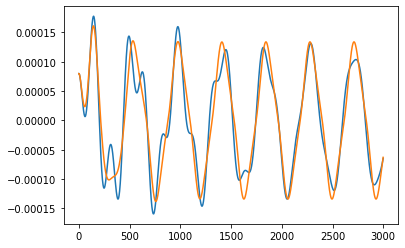

In [ ]:
plt.plot(disps[0,:])
plt.plot(disps[2,:])

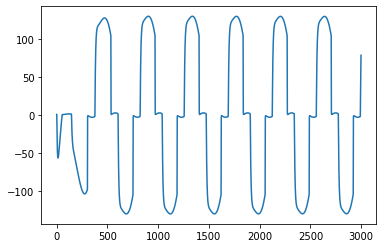

In [ ]:
plt.plot(semiactive_force[1:])

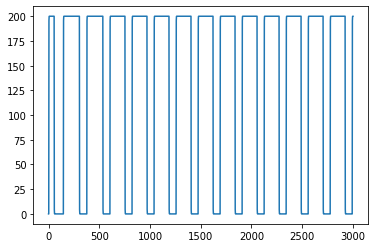

In [ ]:
plt.plot(sad.u)

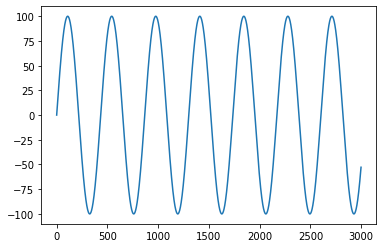

In [ ]:
plt.plot(forces)

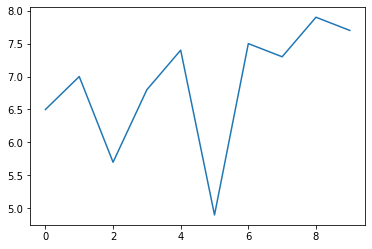

In [ ]:
plt.plot(windspeeds[:10])

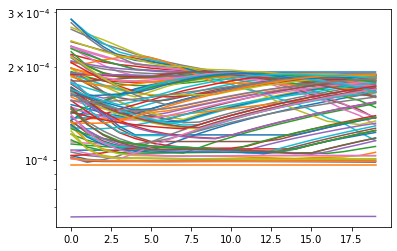

In [ ]:
for i in range(len(windspeeds)):
    plt.semilogy(max_disp[:,i])

In [ ]:
max_disp

array([[0.00010724, 0.00015935, 0.0001123 , ..., 0.        , 0.        ,
        0.        ],
       [0.00010724, 0.0001519 , 0.00011116, ..., 0.        , 0.        ,
        0.        ],
       [0.00010724, 0.00014668, 0.00011019, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00015806, 0.00017813, 0.00014502, ..., 0.        , 0.        ,
        0.        ],
       [0.0001615 , 0.00017997, 0.00014839, ..., 0.        , 0.        ,
        0.        ],
       [0.00016478, 0.00018157, 0.00015186, ..., 0.        , 0.        ,
        0.        ]])